In [1]:
import theano.tensor as T
import theano
import numpy as np
from collections import OrderedDict
import negsamp
import sys
import matplotlib.pylab as plt

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
# Params
d = 200
m = 10
lr = 0.001
epochs = 100
weightfile = 'params-2x_0702.npz'

### Load AlexNet Features (fc7) for all of IAPR-TC12

In [4]:
data = np.load('data/iaprtc_alexfc7.npz')
D = open('data/iaprtc_dictionary.txt').read().splitlines()
train_ims = [ im.split('/')[-1] for im in open('data/iaprtc_trainlist.txt').read().splitlines() ]
test_ims = [ im.split('/')[-1] for im in open('data/iaprtc_testlist.txt').read().splitlines() ]
xTr = data['xTr'].T
yTr = data['yTr'].T
xTe = data['xTe'].T
yTe = data['yTe'].T
wc = yTr.sum(axis=0)+0.01-0.01
d = 100
hidden=4096
f = 4096
V = 291
test_ims_full = [ im for im in open('data/iaprtc_testlist.txt').read().splitlines() ]

### Load Weight Files

In [5]:
Wi = np.load(weightfile)['Wi']
Wc = np.load(weightfile)['Wc']
if 'Wh2' in np.load(weightfile).keys():
    print "Loading W_h2"
    numlayers=2
    Wh2 = np.load(weightfile)['Wh2']
if 'Wh3' in np.load(weightfile).keys():
    print "Loading W_h3"
    numlayers = 3
    Wh3 = np.load(weightfile)['Wh3']
    
print np.load(weightfile).keys()

# Wi = theano.shared(np.load(weightfile)['Wi'])
# Wc = theano.shared(np.load(weightfile)['Wc'])
# if 'Wh' in np.load(weightfile).keys():
#     print "Loading W_h"
#     layers=2
#     Wh = theano.shared(np.load(weightfile)['Wh'])

Loading W_h2
['Epoch', 'Losses', 'Wc', 'Wh2', 'Wi']


In [6]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define rectified linear unit (relu)
def relu(x):
    return np.maximum(x, 0)

### Define neural network function

In [7]:
ns = negsamp.NegativeSampler(wc / wc.sum())

def predictor( inputx ):
    if numlayers == 2:
        yh = sigmoid( Wc.dot(Wi.dot(relu(Wh2.dot(inputx)))) )
    elif numlayers == 3:
        yh = sigmoid (Wc.dot(Wi.dot(relu(Wh3.dot(relu(Wh2.dot(inputx)))))))
    return yh
# predictor = theano.function( inputs =[x], outputs = yh, allow_input_downcast=True )

def sigmoid (x ):
    return 1 / (1 + np.exp(-x) )

### Randomly select an image and display its results

Looking at the 258th image: images/06/6262.jpg
Predicted: trouser, sky, jacket, woman, anorak
Truth:     green, hill, horse, landscape, man


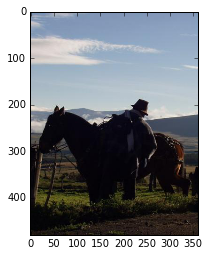

In [11]:
# Randomly select an image
i=np.random.randint(0, yTe.shape[1])

# Run example
inputx=xTe[i];output=yTe[i];
imname='images/'+test_ims_full[i]+'.jpg';
print "Looking at the "+str(i)+"th image: "+imname
im=plt.imread(imname)

# Prediction
ypwords = [D[j] for j in predictor( inputx ).argsort()[::-1] [ 0:(predictor(inputx)>0.5).sum() ] ]
# Truth
ytwords = [D[j] for j in ns.posidx( output ) ]

plt.imshow(im)
print 'Predicted: '+ ', '.join(ypwords)
print 'Truth:     '+ ', '.join(ytwords)

# plt.figure()
# plt.stem( predictor(inputx) )

In [ ]:
import scipy.io as sio
import sys
sys.path.append( '/work/attalos/karllab41-repo/' )

# from attalos.evaluation.evaluation import Eval

# Shape of test and 
ypred = predictor(xTe.T).T
yTe.shape

from oct2py import octave
octave.addpath('../../../evaluation/')
[precision, recall, f1score] = octave.evaluate(yTe.T, ypred.T, 5)
print "P:{}, R:{}, F1{}".format(precision, recall, f1score)

# TestResults = Eval(yTe, ypred)
# TestResults.print_evaluation()

# Save results
# sio.savemat( 'TwoLayerTest.mat', {'Yval': ypred, 'Ytr': yTe} )

### Write binary image vector file

In [ ]:
fp = open('imvecs.bin','wb')
fp.write("%s %s\n" % (str(Wc.shape[0]), str(Wc.shape[1]))) 
for i in range(len(D)):
    fp.write('%s ' % (str(D[i])))
    for j in range(Wc.shape[1]):
        fp.write(Wc[i,j])
    fp.write("\n")
fp.close()

### Write text image vector file

In [ ]:
fp = open('imvecs.txt','wb')
fp.write("%s %s\n" % (str(Wc.shape[0]), str(Wc.shape[1]))) 
for i in range(len(D)):
    fp.write('%s ' % (str(D[i])))
    for j in range(Wc.shape[1]):
        fp.write('%s ' %(str(Wc[i,j])))
    fp.write("\n")
fp.close()